In [14]:
import json
import seaborn as sns
from scipy.stats import sem
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast

In [2]:
with open("diplomacy_data.json") as f:
    data = json.load(f)

In [3]:
df = pd.DataFrame(data) #convert data from list of Dict to a DataFrame
df.head(5)

,seasons,game,betrayal,idx,people
0,"[{'season': 1906.5, 'interaction': {'victim': ...",74,True,0,AT
1,"[{'season': 1911.5, 'interaction': {'victim': ...",165,False,1,EG
2,"[{'season': 1911.0, 'interaction': {'victim': ...",157,False,2,AR
3,"[{'season': 1902.0, 'interaction': {'victim': ...",58,False,3,AR
4,"[{'season': 1910.0, 'interaction': {'victim': ...",45,False,4,IT


In [4]:
def last_support(seasons):
    """return the last season where a player supported the other"""
    for season in seasons: #iterate over each season in a relationship
        if 'support' in season['interaction'].values(): #if the word "support" is in the values of interaction then -->
            support = season['season'] # add the number of the season to supp_season 
        
    return support #return the last support season (e.g 1908.5)

In [5]:
def message_politeness(messages):
    """return the average politeness score for a particular player in a season"""
    return sum(m['politeness'] for m in messages)/len(messages)

In [6]:
def message_discourse(messages):
    """return the average number of discourse markers per sentence"""
    n_sents = sum(m['n_sentences'] for m in messages) * 1.0
    return sum(len(m['lexicon_words'].get("disc_temporal_future", [])) for m in messages) / n_sents

In [7]:
def message_sentiment(messages):
    """return positive sentiment average per sentence"""
    n_sents = sum(m['n_sentences'] for m in messages) * 1.0
    return sum(m['sentiment']['positive'] for m in messages)/n_sents

In [8]:
def add_line(data,politeness,discourse,sentiment,relationship,player = None ,imbalance = True):
    """if imbalance is false add a line to the  plotting_data dataset with respective politeness player type and relationship ending
       if imbalance is true add a line to the imbalance data set with only relationship and score"""
    if imbalance:
        data.append({'imbalance':'','imbalance politeness':politeness,'imbalance discourse':discourse,'imbalance sentiment':sentiment,'relationship':relationship})
    else:
        data.append({'Politeness Score':politeness,'Discourse Score':discourse,'Sentiment Score':sentiment,'Player':player,'relationship':relationship})
        

In [9]:
plotting_data = [] 
imbalance_data = []

for index,row in df.iterrows(): #iterate over the rows of the dataframe
    
    seasons = row.seasons #define the seasons (see dataframe.head() above)
    last_supp = last_support(seasons) #find the season of the last support 
    
    for season in seasons: #iterate over each season 
        
        # check if the two players had an interaction in every single season
        if len(season['messages']['betrayer']) > 0 and len(season['messages']['victim']) > 0: 
            
            polite_betray = message_politeness(season['messages']['betrayer']) #calculate politeness for betrayer
            polite_vict = message_politeness(season['messages']['victim']) #calculate politeness for victim
            disc_betray = message_discourse(season['messages']['betrayer']) #calculate politeness for betrayer
            disc_vict = message_discourse(season['messages']['victim']) #calculate politeness for victim
            sent_betray = message_sentiment(season['messages']['betrayer']) #calculate politeness for betrayer
            sent_vict = message_sentiment(season['messages']['victim']) #calculate politeness for victim
            #if there is a betrayal take only politeness until last support season 
            if row.betrayal==True and season['season']<=last_supp: 
                
                #append dictionnaries corresponding to all 3 where there is betrayal
                add_line(plotting_data,polite_betray,disc_betray,sent_betray,'betrayal','betrayer',False)
                add_line(plotting_data,polite_vict,disc_vict,sent_vict,'betrayal','victim',False)
                add_line(imbalance_data,polite_betray-polite_vict,disc_betray-disc_vict,sent_betray-sent_vict,'betrayal')

            if row.betrayal== False: 

                #append dictionnaries corresponding to all 3 where there is  no betrayal             
                add_line(plotting_data,polite_betray,disc_betray,sent_betray,'no betrayal','betrayer',False)
                add_line(plotting_data,polite_vict,disc_vict,sent_vict,'no betrayal','victim',False)
                add_line(imbalance_data,polite_betray-polite_vict,disc_betray-disc_vict,sent_betray-sent_vict,'no betrayal')


In [10]:
plotting_data = pd.DataFrame(plotting_data) #convert to DataFrame for plotting (easier to plot using seaborn)
imbalance_data = pd.DataFrame(imbalance_data) #convert to DataFram for plotting (easier to plot using seaborn)
plotting_data.head()

,Politeness Score,Discourse Score,Sentiment Score,Player,relationship
0,0.803328,0.120000,0.320000,betrayer,betrayal
1,0.809993,0.129032,0.193548,victim,betrayal
2,0.560083,0.125000,0.062500,betrayer,betrayal
3,0.785508,0.000000,0.444444,victim,betrayal
4,0.982703,0.307692,0.307692,betrayer,betrayal


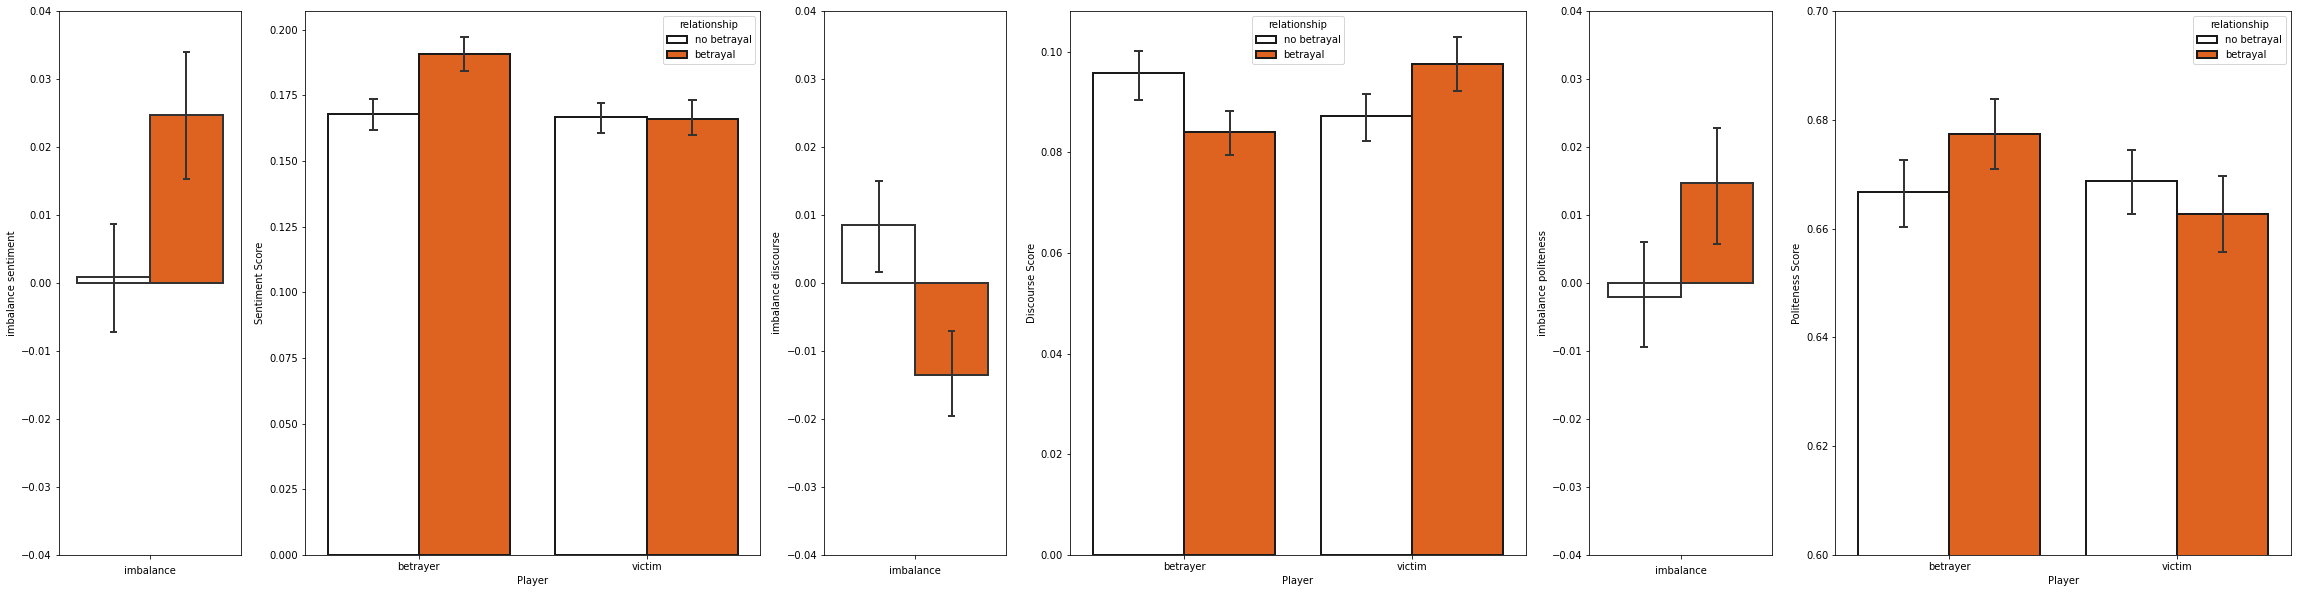

In [11]:
colors = {'no betrayal' : (1,1,1,0),'betrayal' :(1,0.35,0,1)} #Set color palette
fig, axs = plt.subplots(1,6, gridspec_kw={'width_ratios': [2,5,2,5,2,5]}, figsize = (40,10)) #set figure size and subplots
#plot the right graph with bootstrap confidence interval of 68 percent with represents mean +- 1 std 
sns.barplot(x = 'Player',y='Politeness Score',hue = 'relationship',data=plotting_data,ax = axs[5],
            hue_order = ["no betrayal", "betrayal"],ci = 68,capsize = 0.03,
            linewidth=2, errwidth = 2,errcolor=".2", edgecolor=".1", palette = colors)
axs[5].set(ylim=(0.6,0.7)) #set y limits for better viewing 

#plot the left graph with bootstrap confidence interval of 68 percent with represents mean +- 1 std 
sns.barplot(x = 'imbalance',y = 'imbalance politeness', hue = "relationship", data = imbalance_data, ax= axs[4],hue_order = ["no betrayal", "betrayal"], ci = 68, 
            capsize = 0.03, linewidth=2,errwidth = 2,errcolor=".2", edgecolor=".2", palette = colors)
          
axs[4].get_legend().remove() #remove the legend of the left graph because already on the right one 
axs[4].set(ylim=(-0.04,0.04)) #set y limit for better viewing 

sns.barplot(x = 'Player',y='Discourse Score',hue = 'relationship',data=plotting_data,ax = axs[3],
            hue_order = ["no betrayal", "betrayal"],ci = 68,capsize = 0.03,
            linewidth=2, errwidth = 2,errcolor=".2", edgecolor=".1", palette = colors)
#axs[1].set(ylim=(0.6,0.7)) #set y limits for better viewing 

#plot the left graph with bootstrap confidence interval of 68 percent with represents mean +- 1 std 
sns.barplot(x = 'imbalance',y = 'imbalance discourse', hue = "relationship", data = imbalance_data, ax= axs[2],hue_order = ["no betrayal", "betrayal"], ci = 68, 
            capsize = 0.03, linewidth=2,errwidth = 2,errcolor=".2", edgecolor=".2", palette = colors)
          
axs[2].get_legend().remove() #remove the legend of the left graph because already on the right one 
axs[2].set(ylim=(-0.04,0.04)) #set y limit for better viewing 

sns.barplot(x = 'Player',y='Sentiment Score',hue = 'relationship',data=plotting_data,ax = axs[1],
            hue_order = ["no betrayal", "betrayal"],ci = 68,capsize = 0.03,
            linewidth=2, errwidth = 2,errcolor=".2", edgecolor=".1", palette = colors) 

#plot the left graph with bootstrap confidence interval of 68 percent with represents mean +- 1 std 
sns.barplot(x = 'imbalance',y = 'imbalance sentiment', hue = "relationship", data = imbalance_data, ax= axs[0],hue_order = ["no betrayal", "betrayal"], ci = 68, 
            capsize = 0.03, linewidth=2,errwidth = 2,errcolor=".2", edgecolor=".2", palette = colors)
          
axs[0].get_legend().remove() #remove the legend of the left graph because already on the right one 
axs[0].set(ylim=(-0.04,0.04)) #set y limit for better viewing 
#Add general title and save
plt.savefig('all.png')



### General comments about the figure 

As can be seen the figure looks relatively similar to the one in the report. The only exception is the imbalance plot on the no betryal side which seems to go down a bit more in my figure. This might be due to pixel errors since when I tried to make the figure smaller (and the contours a bit thicker) it gave me a smaller bar. The y limits are also different from the original figure.  

In [152]:
data = pd.read_csv('final_data.csv')

In [153]:
data['sentiment'].fillna('[]',inplace = True )
data["sentiment"] = [ast.literal_eval(data["sentiment"][i]) for i in range(data.shape[0])]
data["nb_sentences"] = [len(data["sentiment"][i]) for i in range(data.shape[0])]
data = data[data["nb_sentences"]!=0]
data["discourse_score"] = data.discourse_number/data.nb_sentences
data["sentiment_score"] = [data["sentiment"][i].count(1)/data["nb_sentences"][i] for i in data.index]
data["Receiver perception"] = np.where(data["meta.speaker_intention"]==data["meta.receiver_perception"],'Correct',"Wrong")

In [154]:
data.head()

,id,timestamp,text,speaker,reply_to,conversation_id,meta.speaker_intention,meta.receiver_perception,meta.receiver,meta.absolute_message_index,...,meta.politeness_markers,meta.prediction,meta.pred_score,sentiment,discourse_markers,discourse_number,nb_sentences,discourse_score,sentiment_score,Receiver perception
0,Game1-italy-germany-0,74,Germany!\n\nJust the person I want to speak wi...,italy-Game1,NaN,Game1-italy-germany,Truth,Truth,germany-Game1,74,...,"{'politeness_markers_==Please==': [], 'politen...",0,0.112246,"[0, 0, -1, -1, 0, 0, 1, 0]",[],0,8,0.000,0.125,Correct
1,Game1-italy-germany-1,76,"You've whet my appetite, Italy. What's the sug...",germany-Game1,Game1-italy-germany-0,Game1-italy-germany,Truth,Truth,italy-Game1,76,...,"{'politeness_markers_==Please==': [], 'politen...",0,0.107987,"[0, 0]",[],0,2,0.000,0.000,Correct
2,Game1-italy-germany-2,86,👍,italy-Game1,Game1-italy-germany-1,Game1-italy-germany,Truth,Truth,germany-Game1,86,...,"{'politeness_markers_==Please==': [], 'politen...",0,0.220636,[0],[],0,1,0.000,0.000,Correct
3,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,Game1-italy-germany,Truth,Truth,italy-Game1,87,...,"{'politeness_markers_==Please==': [], 'politen...",1,0.685146,[-1],['while'],1,1,1.000,0.000,Correct
4,Game1-italy-germany-4,89,"Yeah, I can’t say I’ve tried it and it works, ...",italy-Game1,Game1-italy-germany-3,Game1-italy-germany,Truth,NaN,germany-Game1,89,...,"{'politeness_markers_==Please==': [], 'politen...",0,0.171131,"[-1, -1, 0, 0, 0, -1, 1, 1]",['before'],1,8,0.125,0.250,Wrong


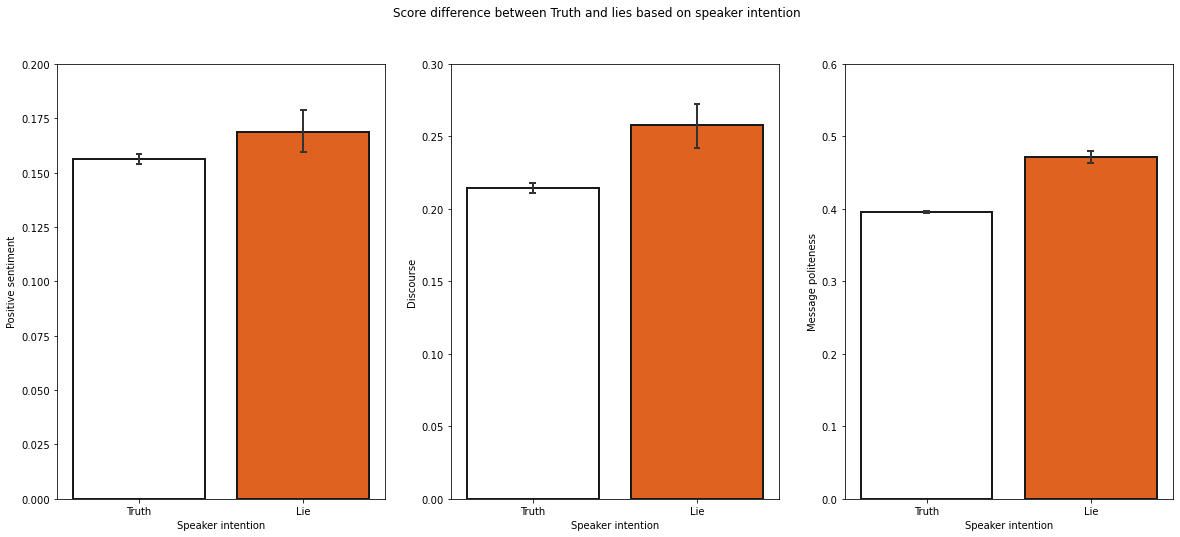

In [160]:
colors = {'Truth' : (1,1,1,0),'Lie' :(1,0.35,0,1)} #Set color palette
fig, axs = plt.subplots(1,3, figsize = (20,8))
sns.barplot(y="sentiment_score",x = "meta.speaker_intention",data = data,ax = axs[0],ci = 68,capsize = 0.03,
            linewidth=2, errwidth = 2,errcolor=".2", edgecolor=".1", palette = colors)
axs[0].set(ylim = (0,0.2),xlabel='Speaker intention',ylabel= 'Positive sentiment')
sns.barplot(y="discourse_score",x = "meta.speaker_intention",data = data,ax = axs[1],ci = 68,capsize = 0.03,
            linewidth=2, errwidth = 2,errcolor=".2", edgecolor=".1", palette = colors)
axs[1].set(ylim = (0,0.3),xlabel='Speaker intention',ylabel= 'Discourse')
sns.barplot(y="meta.pred_score",x = "meta.speaker_intention",data = data,ax = axs[2],ci = 68,capsize = 0.03,
            linewidth=2, errwidth = 2,errcolor=".2", edgecolor=".1", palette = colors)
axs[2].set(ylim = (0,0.6),xlabel='Speaker intention',ylabel= 'Message politeness')
plt.suptitle("Score difference between Truth and lies based on speaker intention")
plt.show()

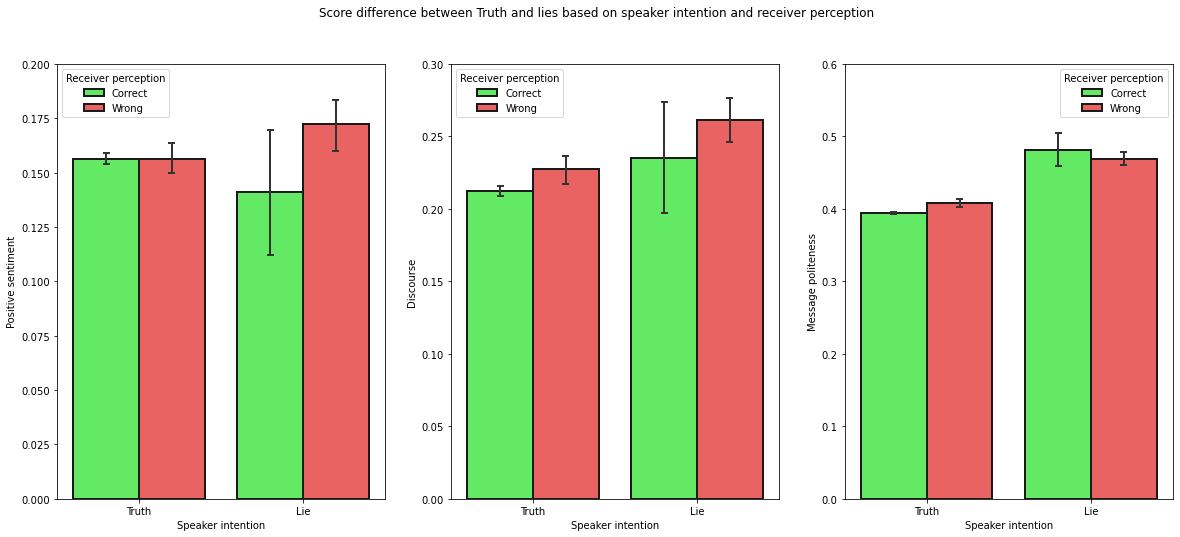

In [161]:
colors = {'Correct' : (0.3,1,0.3,0),'Wrong' :(1,0.3,0.3,1)} #Set color palette
fig, axs = plt.subplots(1,3, figsize = (20,8))
sns.barplot(y="sentiment_score",x = "meta.speaker_intention",hue = "Receiver perception",data = data,ax = axs[0],ci = 68,capsize = 0.03,
            linewidth=2, errwidth = 2,errcolor=".2", edgecolor=".1", palette = colors)
axs[0].set(ylim = (0,0.2),xlabel='Speaker intention',ylabel= 'Positive sentiment')
sns.barplot(y="discourse_score",x = "meta.speaker_intention",data = data,hue = "Receiver perception",ax = axs[1],ci = 68,capsize = 0.03,
            linewidth=2, errwidth = 2,errcolor=".2", edgecolor=".1", palette = colors)
axs[1].set(ylim = (0,0.3),xlabel='Speaker intention',ylabel= 'Discourse')
sns.barplot(y="meta.pred_score",x = "meta.speaker_intention",data = data,hue = "Receiver perception",ax = axs[2],ci = 68,capsize = 0.03,
            linewidth=2, errwidth = 2,errcolor=".2", edgecolor=".1", palette = colors)
axs[2].set(ylim = (0,0.6),xlabel='Speaker intention',ylabel= 'Message politeness')
plt.suptitle("Score difference between Truth and lies based on speaker intention and receiver perception")
plt.show()